In [21]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Flatten, LSTM,Dropout,Conv2D,TimeDistributed
from tensorflow.keras.models import Sequential

In [22]:
eeg=np.load('D:/lab_work_25/AUG/HYBRID EEG EMG/Processed_Data/sub2/sample_eeg.npy')
eeg = eeg[:, 200:875, :]/4
emg=np.load('D:/lab_work_25/AUG/HYBRID EEG EMG/Processed_Data/sub2/sample_emg.npy')
emg=np.moveaxis(emg, 1, 2) 
emg = emg[:, 200:875, :]
kinematic=np.load('D:/lab_work_25/AUG/HYBRID EEG EMG/Processed_Data/sub2/sample_kin.npy')
 
kinematic=np.moveaxis(kinematic, 1, 2)
kinematic = kinematic[:, 200:875, :]
print(eeg.shape, emg.shape, kinematic.shape)

(34, 675, 21) (34, 675, 5) (34, 675, 3)


In [23]:
eeg_trn=eeg[:30, :, :]
emg_trn=emg[:30, :, :]
kinematic_trn=kinematic[:30, :, :]
print(eeg_trn.shape, emg_trn.shape, kinematic_trn.shape)
eeg_test=eeg[30:, :, :]
emg_test=emg[30:, :, :]
kinematic_test=kinematic[30:, :, :]
print(eeg_test.shape, emg_test.shape, kinematic_test.shape)

(30, 675, 21) (30, 675, 5) (30, 675, 3)
(4, 675, 21) (4, 675, 5) (4, 675, 3)


In [24]:
# full_coupled_kuramoto_compact.py
import numpy as np, tensorflow as tf

# ---------- Utilities ----------
def symmetric_zero_diag_glorot(shape, dtype=None):
    """Glorot init, symmetrize, and zero diagonal"""
    W = tf.keras.initializers.GlorotUniform()(shape, dtype=dtype)
    return tf.linalg.set_diag(0.5*(W+tf.transpose(W)), tf.zeros(shape[0], dtype=dtype))

def symmetrize_and_zero_diag(W):
    W = 0.5*(W+tf.transpose(W))
    return tf.linalg.set_diag(W, tf.zeros([tf.shape(W)[0]], dtype=W.dtype))

class ClipConstraint(tf.keras.constraints.Constraint):
    """Custom constraint to clip weights between [min_val, max_val]."""
    def __init__(self, min_val, max_val):
        self.min_val = min_val
        self.max_val = max_val
    def __call__(self, w):
        return tf.clip_by_value(w, self.min_val, self.max_val)

# ---------- Coupled Kuramoto Layer ----------
class CoupledKuramoto(tf.keras.layers.Layer):
    def __init__(self, units_A, units_B, num_steps=675, dt=1/100,
                 min_omega=0.1, max_omega=30.0, hebb_lr=0.0, **kwargs):
        super().__init__(**kwargs)
        self.units_A = units_A
        self.units_B = units_B
        self.num_steps = num_steps
        self.dt = dt
        self.min_omega = min_omega
        self.max_omega = max_omega
        self.hebb_lr = hebb_lr

    def build(self, _):
        A, B = self.units_A, self.units_B
        self.omega_A = self.add_weight(
            shape=(A,),
            initializer="random_uniform",
            trainable=True,
            constraint=ClipConstraint(self.min_omega, self.max_omega)
        )
        self.omega_B = self.add_weight(
            shape=(B,),
            initializer="random_uniform",
            trainable=True,
            constraint=ClipConstraint(self.min_omega, self.max_omega)
        )
        self.W_AA = self.add_weight(shape=(A,A), initializer=symmetric_zero_diag_glorot, trainable=True)
        self.W_BB = self.add_weight(shape=(B,B), initializer=symmetric_zero_diag_glorot, trainable=True)
        self.W_AB = self.add_weight(shape=(A,B), initializer="glorot_uniform", trainable=True)
        self.W_BA = self.add_weight(shape=(B,A), initializer="glorot_uniform", trainable=True)

    def call(self, inputs, training=False):
        X_A, X_B = inputs
        T = tf.shape(X_A)[1]
        N = tf.minimum(self.num_steps, T)
        bsz = tf.shape(X_A)[0]

        phis_A = tf.zeros((bsz, self.units_A))
        phis_B = tf.zeros((bsz, self.units_B))

        XA = tf.TensorArray(tf.float32, N).unstack(tf.transpose(X_A[:,:N,:],[1,0,2]))
        XB = tf.TensorArray(tf.float32, N).unstack(tf.transpose(X_B[:,:N,:],[1,0,2]))

        outA, outB = tf.TensorArray(tf.float32, N), tf.TensorArray(tf.float32, N)

        def body(t, phA, phB, WAA, WBB, WAB, WBA, TA, TB):
            dAA = tf.expand_dims(phA,2)-tf.expand_dims(phA,1)
            dBB = tf.expand_dims(phB,2)-tf.expand_dims(phB,1)
            dAB = tf.expand_dims(phA,2)-tf.expand_dims(phB,1)
            dBA = tf.expand_dims(phB,2)-tf.expand_dims(phA,1)

            phA = phA+(self.omega_A+4*XA.read(t)+1e-4*(
                tf.reduce_sum(WAA*tf.sin(dAA),-1)+tf.reduce_sum(WAB*tf.sin(dAB),-1)))*self.dt
            phB = phB+(self.omega_B+4*XB.read(t)+1e-4*(
                tf.reduce_sum(WBB*tf.sin(dBB),-1)+tf.reduce_sum(WBA*tf.sin(dBA),-1)))*self.dt

            phA, phB = tf.math.floormod(phA, 2*np.pi), tf.math.floormod(phB, 2*np.pi)

            if training and self.hebb_lr > 0:
                def hebb():
                    cos = lambda d: tf.reduce_mean(tf.cos(d),0)
                    dWAA, dWBB = self.hebb_lr*cos(dAA)/self.units_A, self.hebb_lr*cos(dBB)/self.units_B
                    dWAB, dWBA = self.hebb_lr*cos(dAB)/self.units_B, self.hebb_lr*cos(dBA)/self.units_A
                    return (symmetrize_and_zero_diag(WAA+dWAA),
                            symmetrize_and_zero_diag(WBB+dWBB),
                            tf.clip_by_value(WAB+dWAB, -5, 5),
                            tf.clip_by_value(WBA+dWBA, -5, 5))
                WAA, WBB, WAB, WBA = hebb()

            TA, TB = TA.write(t, phA), TB.write(t, phB)
            return t+1, phA, phB, WAA, WBB, WAB, WBA, TA, TB

        _,_,_,WAA,WBB,WAB,WBA,TA,TB = tf.while_loop(
            lambda t, *_: t<N, body,
            [0, phis_A, phis_B, self.W_AA, self.W_BB, self.W_AB, self.W_BA, outA, outB],
            shape_invariants=[tf.TensorShape([]),
                              tf.TensorShape([None,self.units_A]),
                              tf.TensorShape([None,self.units_B]),
                              tf.TensorShape([self.units_A,self.units_A]),
                              tf.TensorShape([self.units_B,self.units_B]),
                              tf.TensorShape([self.units_A,self.units_B]),
                              tf.TensorShape([self.units_B,self.units_A]),
                              tf.TensorShape(None), tf.TensorShape(None)]
        )

        if self.hebb_lr > 0:
            [v.assign(n) for v,n in zip(
                [self.W_AA, self.W_BB, self.W_AB, self.W_BA],
                [WAA, WBB, WAB, WBA]
            )]

        phiA, phiB = tf.transpose(TA.stack(), [1,0,2]), tf.transpose(TB.stack(), [1,0,2])
        return tf.cos(phiA), tf.sin(phiA), tf.cos(phiB), tf.sin(phiB)

# ---------- Wrapper Model ----------
class ParallelCoupledKuramotoModel(tf.keras.Model):
    def __init__(self, featA, featB, uA, uB, uE=16, outD=3, steps=725, hebb=0.0):
        super().__init__()
        self.pA,self.pB = [tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(u, activation='relu')) for u in [uA,uB]]
        self.coupled = CoupledKuramoto(uA, uB, num_steps=steps, hebb_lr=hebb)
        self.embed = lambda: tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(uE, activation='relu'))
        self.A_r,self.A_i,self.B_r,self.B_i = [self.embed() for _ in range(4)]
        self.comb = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(uE, activation='tanh'))
        self.out = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(outD))

    def call(self, inputs, training=False):
        XA, XB = [f(i) for f,i in zip([self.pA,self.pB],inputs)]
        cA,sA,cB,sB = self.coupled([XA,XB], training=training)
        hA,hB = tf.concat([self.A_r(cA), self.A_i(sA)],-1), tf.concat([self.B_r(cB), self.B_i(sB)],-1)
        return self.out(self.comb(tf.concat([hA,hB],-1)))

# ---------- Demo ----------
if __name__=="__main__":
    tf.random.set_seed(0); np.random.seed(0)
    B,T,fA,fB,uA,uB,outD = 6,675,21,5,40,40,3

    # Dummy synthetic data for demo
    X_A = eeg_trn[:, :T, :fA].astype(np.float32)
    X_B = emg_trn[:, :T, :fB].astype(np.float32)
    y = kinematic_trn[:, :T, :outD].astype(np.float32)

    model = ParallelCoupledKuramotoModel(fA,fB,uA,uB,outD=outD,steps=T,hebb=1e-3)
    model.compile(optimizer="adam", loss="mse")
    model.build([(None,T,fA),(None,T,fB)])
    model.summary()
    model.fit([X_A,X_B], y, epochs=200, batch_size=2, verbose=2)

    # Extract phases
    pA,pB = model.pA(X_A), model.pB(X_B)
    cA,sA,cB,sB = model.coupled([pA,pB], training=False)
    phiA,phiB = [np.mod(np.arctan2(s.numpy(),c.numpy()),2*np.pi) for s,c in [(sA,cA),(sB,cB)]]

    # PLV
    PLV = np.zeros((uA,uB))
    for i in range(uA):
        for j in range(uB):
            diff = (phiA[:,:,i].reshape(-1) - phiB[:,:,j].reshape(-1))
            PLV[i,j] = np.abs(np.mean(np.exp(1j*diff)))
    print("PLV sample:", np.round(PLV[:3,:3],3))


Model: "parallel_coupled_kuramoto_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_40 (TimeDi  multiple                 880       
 stributed)                                                      
                                                                 
 time_distributed_41 (TimeDi  multiple                 240       
 stributed)                                                      
                                                                 
 coupled_kuramoto_5 (Coupled  multiple                 6480      
 Kuramoto)                                                       
                                                                 
 time_distributed_42 (TimeDi  multiple                 656       
 stributed)                                                      
                                                                 
 time_distributed_43 (TimeDi  mul

In [25]:
# Flatten matrices for comparison
W_AB = model.coupled.W_AB.numpy()
W_BA = model.coupled.W_BA.numpy()

# Correlation between PLV and inter-population weights
corr_AB = np.corrcoef(W_AB.flatten(), PLV.flatten())[0,1]
print("Correlation between W_AB and PLV:", np.round(corr_AB,3))


Correlation between W_AB and PLV: 0.757


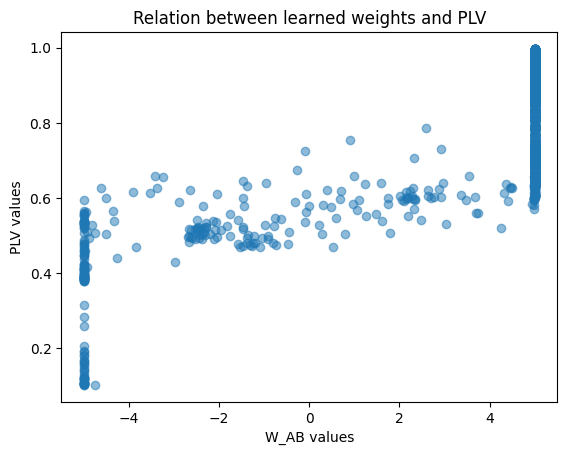

In [27]:
import matplotlib.pyplot as plt

plt.scatter(W_AB.flatten(), PLV.flatten(), alpha=0.5)
plt.xlabel("W_AB values")
plt.ylabel("PLV values")
plt.title("Relation between learned weights and PLV")
plt.show()


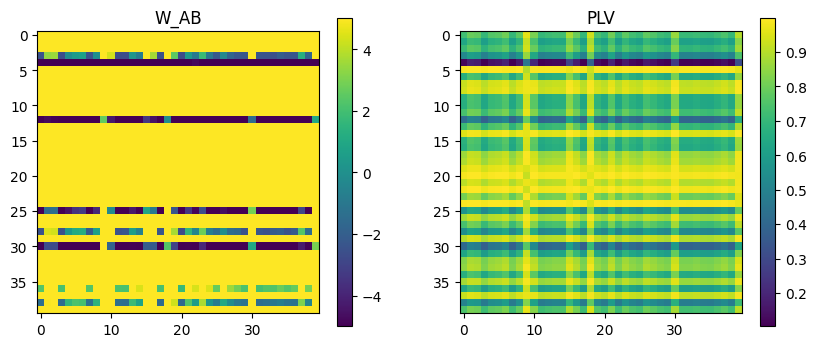

In [28]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize=(10,4))
im0 = axs[0].imshow(W_AB, cmap='viridis'); axs[0].set_title("W_AB")
im1 = axs[1].imshow(PLV, cmap='viridis'); axs[1].set_title("PLV")
fig.colorbar(im0, ax=axs[0]); fig.colorbar(im1, ax=axs[1])
plt.show()
